In [1]:
!pwd

/data/FoodDetection/Object_Detection/yolov5-test/yolov5/dataset


1. for문으로 데이터프레임 합치기

https://hashcode.co.kr/questions/9219/%ED%8C%8C%EC%9D%B4%EC%8D%AC-for%EB%AC%B8-%EC%97%B0%EB%8F%84%EB%B3%84-%EB%B0%98%EB%B3%B5-%EB%8D%B0%EC%9D%B4%ED%84%B0%ED%94%84%EB%A0%88%EC%9E%84%EC%83%9D%EC%84%B1


2. 데이터프레임 엑셀 시트별 저장

https://sromi.tistory.com/8

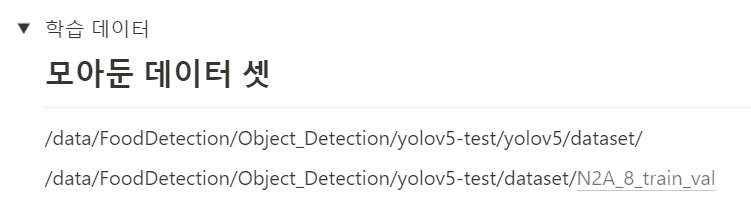

위의 경로 2곳에서 함수를 각각 실행시켜봐야한다!

# 함수

In [2]:
import re
import pandas as pd
import numpy as np
import os, glob
import shutil


df_total_list = pd.read_excel('class확정_20210707.xlsx', engine='openpyxl') # 엑셀 파일 로드
df_total_list = df_total_list.iloc[:,1:3].rename(columns={'라벨 인덱스':'class_number', 'FOOD_NM':'class_name'}) # 엑셀 컬럼 중 필요한 컬럼만 가져오기
df_total_list.dropna(inplace=True) # 널값 제거
df_total_list.class_number = df_total_list.class_number.astype(int) # class_number를 int로 변환

In [68]:
# class확정 엑셀 파일과 train,val폴더의 labels를 비교하는 함수
def check_data(dirs_name): # train, val 폴더들을 넣음.
    
    print(f'=========={dirs_name}==========')
    
    txt_classes = [] # txt 파일 안의 클래스를 담을 리스트.
    
    os.chdir(f'{dirs_name}/labels') # train, val 폴더안의 labels로 이동.
    des = os.getcwd()
    print(f'{dirs_name}/labels로 이동')
    files = os.listdir() # labels 폴더 내의 txt 파일들.
    print(f'{dirs_name}/labels 내의 txt 파일 개수: ', len(files))
#     print(files)
    
    
    empty_file = [] # 내용이 없는 file을 저장할 리스트
    
    for file in files: # for문으로 돌면서 txt 파일 하나씩 꺼냄.
        # txt 파일을 읽음.
        with open(file, "r") as f:
            text = f.read()
            # txt 파일 내용이 비어있을 경우, bin_txt 폴더에 'dirs_name이름_txt이름'으로 옮김.
            if text is "":
                empty_file.append(file)
                
###################### 빈 txt를 삭제하는 부분 #########################
###################### 처음에는 pass만 켜두고 #########################
######################## 실행해봐라!! #################################
#                 os.remove(f'{file}')
#                 if not os.path.exists('../../bin_txt'):
#                     os.makedirs('../../bin_txt')
#                 if not os.path.exists(f'../../bin_txt/{dirs_name}_bin_txt'):
#                     os.makedirs(f'../../bin_txt/{dirs_name}_bin_txt')
#                 os.chdir(f'../images')
#                 shutil.move(f'{file[:-3]}jpg', f'../../bin_txt/{dirs_name}_bin_txt')
#                 shutil.move(f'{file[:-3]}txt', f'../../bin_txt/{dirs_name}_bin_txt')
#                 os.chdir(f'../labels')
                pass
########################################################################


            # 내용이 있을 경우 정규표현식으로 내용의 첫 부분인 클래스만 추출
            else:
                p = re.compile(".*?\s")
                class_ = p.match(text).group()[:-1]
                # texts에 추출한 txt 저장
                txt_classes.append(class_)
    
    print('내용이 없는 txt 개수: ', len(empty_file))
    if len(empty_file) != 0:
        print(f'--{dirs_name}_bin_txt 폴더에 이동--')
    
    list_to_dict = {} # txt_classes의 '클래스_번호:개수'를 담을 딕셔너리
    
    # 내용이 있는 file들의 '클래스_번호:개수' 맵핑
    for text in txt_classes:
        if text in list_to_dict:
            list_to_dict[text] = list_to_dict[text]+1
        else:
            list_to_dict[text] = 1
    
    df = pd.DataFrame(list_to_dict.items(), columns=['class_number', 'counts']) # 딕셔너리를 데이터프레임으로 변환
    df.class_number = df.class_number.astype(int) # class_number를 int로 변환
    merge_df = pd.merge(df, df_total_list, on='class_number', how='left') # df_total_list와 병합
    merge_df = merge_df[['class_number', 'class_name', 'counts']] # 컬럼 순서 바꿈
    merge_df['folder'] = dirs_name # 폴더 이름 컬럼 추가
#     merge_df.to_excel(f'{dirs_name}.xlsx')


    # 폴더 안의 labels의 txt 파일들의 개수와 merge_df의 counts 개수가 일치하는지 확인!
    print(f'생성된 데이터프레임의 counts 개수: {len(files)}-{len(empty_file)} =', merge_df.counts.sum())
    if len(files)-len(empty_file) != merge_df.counts.sum():
        print('!!!!!!!!!!!!!!로드된 엑셀파일의 라벨 인덱스와 FOOD_NM에 이상이 있다!!!!!!!!!!')

    os.chdir(f'../..') # 현재 위치로 다시 이동
    print('\n')
    
    return merge_df



# check_data 함수실행 및 train_val 통합, 폴더 별로 엑셀 시트에 저장하는 함수

def execution():
    des = os.getcwd()
    des = des.split('/')[-1]
    print('현재 경로: ', des)
    print('')
    writer=pd.ExcelWriter(f'{des}.xlsx', engine='openpyxl')
    
    dirs = sorted(list(filter(os.path.isdir, glob.glob('*'))))
    train_list  = list(filter(lambda x: x.startswith('train'), dirs))
    val_list  = list(filter(lambda x: x.startswith('val'), dirs))
    train_val_list = train_list+val_list
    
    df_base= pd.DataFrame(columns=['class_number', 'class_name', 'counts'])
    
    for number, dir_ in enumerate(train_val_list):
        number = check_data(dir_)
        number = number[['class_number', 'class_name', 'counts']]
        number.to_excel(writer, sheet_name= f'{dir_}')
        df_base = pd.concat([df_base, number], axis=0, ignore_index=True)
        
    df_base.class_number = df_base.class_number.astype(int)
    df_base.counts = df_base.counts.astype(int)
    df_base = df_base.groupby('class_number').sum().reset_index()
    merge_df = pd.merge(df_base, df_total_list, on='class_number', how='left') # df_total_list와 병합
    merge_df = merge_df[['class_number', 'class_name', 'counts']] # 컬럼 순서 바꿈
    merge_df.to_excel(writer, sheet_name=f'train_val_total')
    writer.save()
    
    print('실행 완료')
    
    return merge_df

In [69]:
!pwd

/data/FoodDetection/Object_Detection/yolov5-test/yolov5/dataset


In [66]:
# %cd ../../yolov5/dataset

/data/FoodDetection/Object_Detection/yolov5-test/yolov5/dataset


In [70]:
# 실행
df1 = execution()
df1

현재 경로:  dataset

==========train1==========
train1/labels로 이동
train1/labels 내의 txt 파일 개수:  41924
내용이 없는 txt 개수:  0
생성된 데이터프레임의 counts 개수: 41924-0 = 41924


==========train2==========
train2/labels로 이동
train2/labels 내의 txt 파일 개수:  89518
내용이 없는 txt 개수:  0
생성된 데이터프레임의 counts 개수: 89518-0 = 89518


==========train3==========
train3/labels로 이동
train3/labels 내의 txt 파일 개수:  30675
내용이 없는 txt 개수:  0
생성된 데이터프레임의 counts 개수: 30675-0 = 30675


==========train4==========
train4/labels로 이동
train4/labels 내의 txt 파일 개수:  3595
내용이 없는 txt 개수:  0
생성된 데이터프레임의 counts 개수: 3595-0 = 3595


==========train5==========
train5/labels로 이동
train5/labels 내의 txt 파일 개수:  13188
내용이 없는 txt 개수:  0
생성된 데이터프레임의 counts 개수: 13188-0 = 13188


==========train6==========
train6/labels로 이동
train6/labels 내의 txt 파일 개수:  3963
내용이 없는 txt 개수:  0
생성된 데이터프레임의 counts 개수: 3963-0 = 3963


==========train7==========
train7/labels로 이동
train7/labels 내의 txt 파일 개수:  28507
내용이 없는 txt 개수:  0
생성된 데이터프레임의 counts 개수: 28507-0 = 28507


==========train8

,class_number,class_name,counts
0,0,가리비구이,570
1,1,가자미구이,361
2,2,가자미조림,672
3,3,가지나물,801
4,4,가지냉국,595
...,...,...,...
694,696,파래야채튀김,165
695,697,콩나물무침,156
696,698,소고기 구이,403
697,700,피자,773


In [681]:
# 실행
execution()

==========train1==========
train1/labels로 이동
train1/labels 내의 txt 파일 개수:  41924
내용이 없는 txt 개수:  0
생성된 데이터프레임의 counts 개수: 41924-0 = 41924


==========train2==========
train2/labels로 이동
train2/labels 내의 txt 파일 개수:  89518
내용이 없는 txt 개수:  0
생성된 데이터프레임의 counts 개수: 89518-0 = 89518


==========train3==========
train3/labels로 이동
train3/labels 내의 txt 파일 개수:  30675
내용이 없는 txt 개수:  0
생성된 데이터프레임의 counts 개수: 30675-0 = 30675


==========train4==========
train4/labels로 이동
train4/labels 내의 txt 파일 개수:  3595
내용이 없는 txt 개수:  0
생성된 데이터프레임의 counts 개수: 3595-0 = 3595


==========train5==========
train5/labels로 이동
train5/labels 내의 txt 파일 개수:  13188
내용이 없는 txt 개수:  0
생성된 데이터프레임의 counts 개수: 13188-0 = 13188


==========train6==========
train6/labels로 이동
train6/labels 내의 txt 파일 개수:  3963
내용이 없는 txt 개수:  0
생성된 데이터프레임의 counts 개수: 3963-0 = 3963


==========train7==========
train7/labels로 이동
train7/labels 내의 txt 파일 개수:  28507
내용이 없는 txt 개수:  0
생성된 데이터프레임의 counts 개수: 28507-0 = 28507


==========train8==========
train8

,class_number,class_name,counts
0,0,가리비구이,570
1,1,가자미구이,361
2,2,가자미조림,672
3,3,가지나물,801
4,4,가지냉국,595
...,...,...,...
694,696,파래야채튀김,165
695,697,콩나물무침,156
696,698,소고기 구이,403
697,700,피자,773


In [71]:
!pwd

/data/FoodDetection/Object_Detection/yolov5-test/yolov5/dataset


/data/FoodDetection/Object_Detection/yolov5-test/dataset/N2A_8_train_val로 이동

In [72]:
%cd ../../dataset/N2A_8_train_val

/data/FoodDetection/Object_Detection/yolov5-test/dataset/N2A_8_train_val


In [73]:
# 실행
df2 = execution()
df2

현재 경로:  N2A_8_train_val

==========train_N2A_8==========
train_N2A_8/labels로 이동
train_N2A_8/labels 내의 txt 파일 개수:  6542
내용이 없는 txt 개수:  0
생성된 데이터프레임의 counts 개수: 6542-0 = 6542


==========val_N2A_8==========
val_N2A_8/labels로 이동
val_N2A_8/labels 내의 txt 파일 개수:  729
내용이 없는 txt 개수:  0
생성된 데이터프레임의 counts 개수: 729-0 = 729


실행 완료


,class_number,class_name,counts
0,20,곱창볶음,34
1,46,단무지,1
2,61,도토리묵무침,1
3,77,갈비탕,2
4,87,깍두기,1
5,94,더덕구이,1
6,97,된장찌개,1
7,98,라면,1
8,99,만두국,542
9,103,매생이국,4


N2A_8_train_val에서 새로 추가된 클래스 확인

In [79]:
set(df2.class_name.to_list()) - set(df1.class_name.to_list())
# 700이 맞다!

{'계란(달걀), 난황, 생것',
 '계란(달걀)국',
 '계란(달걀)덮밥',
 '곱창구이',
 '과메기',
 '닭찜,찜닭',
 '떡국',
 '메추리알조림',
 '부추, 산부추, 생것',
 '생선조림',
 '장어구이',
 '장어덮밥'}

In [84]:
total = pd.concat([df1, df2], ignore_index=True).groupby('class_number').sum()
total

,counts
class_number,
0,570
1,361
2,672
3,801
4,595
...,...
811,861
822,925
824,863


In [85]:
merge_df = pd.merge(total, df_total_list, on='class_number', how='left') # df_total_list와 병합
merge_df = merge_df[['class_number', 'class_name', 'counts']] # 컬럼 순서 바꿈
merge_df

,class_number,class_name,counts
0,0,가리비구이,570
1,1,가자미구이,361
2,2,가자미조림,672
3,3,가지나물,801
4,4,가지냉국,595
...,...,...,...
706,811,계란(달걀)국,861
707,822,곱창구이,925
708,824,과메기,863
709,825,생선조림,771


In [86]:
!pwd

/data/FoodDetection/Object_Detection/yolov5-test/dataset/N2A_8_train_val


In [88]:
merge_df.to_excel('dataset+N2A.xlsx')